In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### visualization functions

In [2]:
def digit_plot(digit):
    '''
    Plot a single digit.
    input : (1, 784) array
    '''
    digit_reshaped = digit.values.reshape(28,28)
    
    fig, ax = plt.subplots()
    ax.imshow(digit_reshaped, cmap='gray_r')
    ax.axis('off')
    
def multidigits_plot(digits, size=None, shape=None, secure=True):
    '''
    Plot n digits, max 100 digits if secure=True.
    
    Input : 
    - digits : dataframe of n digits or (n, 784) array.
    - size : integer, or list or tuple of 2 integers, to set size of figure.
    - shape : shape of the axes, then shape=size, except size is set to an integer.
    - secure : if set to True, will raise an error if digits has more than 100 rows.
    '''
    n = len(digits)
    if secure and n>100:
        raise ValueError('Too much digits to plot, make sure there is maximum 100 digits to plot, or set secure to False')
    
    # find the number of rows x, and columns y, for the axes of the plot
    if shape == None:
        for i in range(1, n):
            if (i*(i-1)) <= n:
                x = i
                y = i
                if x*y >= n:
                    break
                x = i
                y = i+1
                if x*y >= n:
                    break   
    else:
        x = shape[0]
        y = shape[1]
        if not isinstance(size, int):
            size = shape
    fig, ax = plt.subplots(x, y)
    ratio = x/y
    
    # set figure size
    if size==None:
        size = 8
        fig.set_size_inches(size/ratio, size*ratio)
    if isinstance(size, int):
        fig.set_size_inches(size/ratio, size*ratio)
    if isinstance(size, (list, tuple)):
        fig.set_size_inches(size[1], size[0])
    
    axes = ax.ravel()

    # plot the digits if digits is dataframe
    if isinstance(digits, pd.core.frame.DataFrame):
        for ax, index in zip(axes, digits.index):
            digit = digits.loc[index, :]
            digit_reshaped = digit.values.reshape(28,28)
            ax.imshow(digit_reshaped, cmap='gray_r')
    
    # plot the digits if digits is a 2D array
    else:
        for ax, digit in zip(axes, digits):
            digit_reshaped = digit.values.reshape(28,28)
            ax.imshow(digit_reshaped, cmap='gray_r')
    
    # hide axis
    for ax in axes:
        ax.axis('off')

### Loading the data and preparing the test set

In [3]:
from sklearn.model_selection import train_test_split

digits = pd.read_csv('Data/train.csv')

X = digits.drop('label', axis=1)
y = digits['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### The distribution of digits in  the dataset.

It's quite balanced, not a perfect 10% for every digits, but that's fine.

In [4]:
y_count = y.value_counts()
y_pct = y_count/len(y)*100
y_pct.round(2)

1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

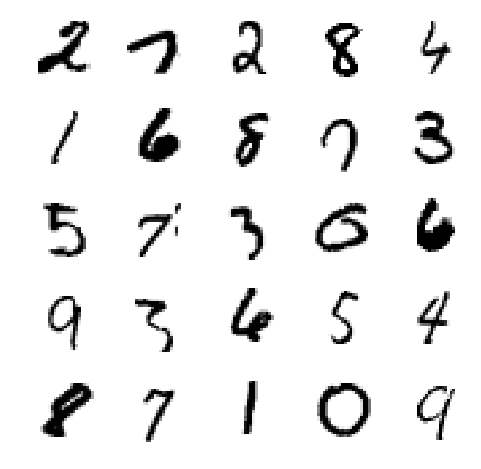

In [5]:
digits = X_train.sample(25)
multidigits_plot(digits)

In [6]:
from sklearn.metrics import accuracy_score
import time

def multi_estimators_results(estimators, X_train, X_test, y_train, y_test):
    '''
    input : - estimators :list of estimators
            - X_train, X_test, y_train, y_test : training and test set
    output : tuple : results dataframe and list of estimators fitted
    '''
    cols= ['Train Accuracy Score', 'Test Accuracy Score', 'Fitting Time']
    results_df = pd.DataFrame(columns=cols)

    for estimator in estimators:
        #get estimator name
        estimator_name = estimator.__class__.__name__

        # fit estimator and get time of fit
        t0 = time.time()
        estimator.fit(X_train, y_train)
        t1 = time.time()
        results_df.loc[estimator_name, 'Fitting Time'] = t1 - t0

        # get train accuracy score
        y_train_pred = estimator.predict(X_train)
        train_score = accuracy_score(y_train, y_train_pred)
        results_df.loc[estimator_name, 'Train Accuracy Score'] = train_score

        # get Test accuracy score
        y_test_pred = estimator.predict(X_test)
        test_score = accuracy_score(y_test, y_test_pred)
        results_df.loc[estimator_name, 'Test Accuracy Score'] = test_score

    return results_df, estimators

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

estimators = [LogisticRegression(solver='lbfgs'),
              LinearSVC(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              ExtraTreesClassifier()
              ]

# reduced training set, to get results quicker
X_train_reduced = X_train.sample(frac=0.2)
y_train_reduced = y_train.loc[X_train_reduced.index]

results_df, estimators_fitted = multi_estimators_results(estimators, X_train_reduced, X_test, y_train_reduced, y_test)
results_df

,Train Accuracy Score,Test Accuracy Score,Fitting Time
LogisticRegression,0.984524,0.860119,6.06804
LinearSVC,0.969345,0.84381,3.50133
DecisionTreeClassifier,1,0.794167,0.975149
RandomForestClassifier,0.998958,0.898214,0.280687
ExtraTreesClassifier,1,0.911071,0.282188


We see a lot of overfitting for all classifiers. Optimizing the parameters for these classifiers is necessary to improve test accuracy.

First, let's see what we get if we use the complete train set to fit our models.

In [8]:
results_df, estimators_fitted = multi_estimators_results(estimators, X_train, X_test, y_train, y_test)
results_df

,Train Accuracy Score,Test Accuracy Score,Fitting Time
LogisticRegression,0.934286,0.908095,28.6146
LinearSVC,0.88,0.859405,65.6322
DecisionTreeClassifier,1,0.854881,7.3569
RandomForestClassifier,0.999077,0.93869,1.73415
ExtraTreesClassifier,1,0.944405,1.96131


We still observe a lot of overfitting for all classifier, except LinearSVC and LogisticRegression. Now, we'll use Principal Components Analysis to reduce the number of features. It's very useful here because, as we can see it in the images of digits, there is a lot of pixels useless for the classifiers. 